### Connecting to the database on SQL Server.

In [2]:
import pyodbc

conn = pyodbc.connect(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=DESKTOP-JACG8CO\\SQLEXPRESS;"
    "DATABASE=RealEstateAgency;"
    "Trusted_Connection=yes;"
)
print("Connection went successfully!")

Connection went successfully!


In [3]:
import pandas as pd
query = "select table_name from information_schema.tables;"
result = pd.read_sql_query(query, conn)
result

C:\Users\mokha\AppData\Local\Temp\ipykernel_2204\4229557346.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(query, conn)


,table_name
0,Properties
1,Clients
2,Agents
3,Sales
4,Visits
5,sysdiagrams


### Exploring 'Properties' table.

In [4]:
properties = pd.read_sql_query("select * from Properties", conn)
properties.sample(10)

C:\Users\mokha\AppData\Local\Temp\ipykernel_2204\2605173858.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  properties = pd.read_sql_query("select * from Properties", conn)


,PropertyID,PropertyType,Location,Size_sqm,PriceUSD
926,927,Villa,Houston,111,979433
721,722,Office,New York,345,238205
655,656,Retail,Chicago,241,60935
371,372,Warehouse,New York,115,487971
526,527,Villa,Houston,123,427154
355,356,Warehouse,Houston,115,221889
165,166,Warehouse,Chicago,115,688052
487,488,Apartment,Los Angeles,120,362654
576,577,Apartment,Los Angeles,416,158282
793,794,Retail,Los Angeles,338,876110


#### *Data Quality & Structure Checks*

In [5]:
#Check for Missing Values
properties.isnull().sum()

PropertyID      0
PropertyType    0
Location        0
Size_sqm        0
PriceUSD        0
dtype: int64

In [6]:
#Identify Duplicates
properties.duplicated().sum()

0

In [7]:
#Verify Data Types
properties.dtypes

PropertyID       int64
PropertyType    object
Location        object
Size_sqm         int64
PriceUSD         int64
dtype: object

In [8]:
#Inspect Unique Values
print("Available property types:", properties.PropertyType.unique())
print("Locations of properties:", properties.Location.unique())

Available property types: ['Warehouse' 'Villa' 'Retail' 'Apartment' 'Office']
Locations of properties: ['New York' 'Miami' 'Los Angeles' 'Chicago' 'Houston']


#### *Descriptive Statistics*

In [9]:
properties[['Size_sqm', 'PriceUSD']].describe()

,Size_sqm,PriceUSD
count,1000.000000,1000.000000
mean,266.800000,520742.562000
std,128.249803,278213.721261
min,50.000000,51696.000000
25%,158.750000,272553.750000
50%,254.000000,521777.000000
75%,374.500000,760105.250000
max,500.000000,998279.000000


In [10]:
properties['PropertyType'].value_counts()
properties['Location'].value_counts()

Location
New York       206
Miami          205
Los Angeles    198
Houston        198
Chicago        193
Name: count, dtype: int64

#### *Exploratory Visualizations*

c:\Users\mokha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Price in Million USD')

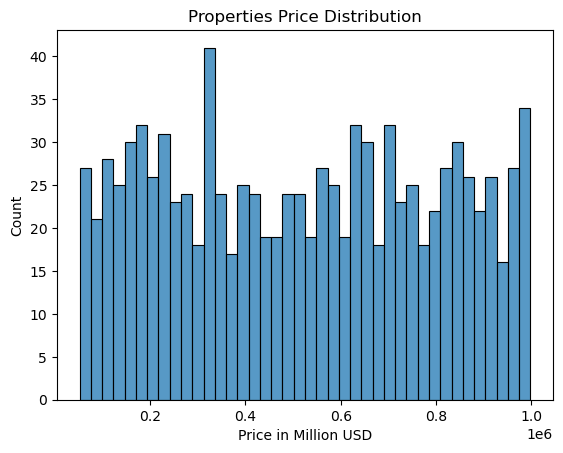

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(properties.PriceUSD, bins=40)
plt.title("Properties Price Distribution")
plt.xlabel("Price in Million USD")

In [12]:
import numpy as np
groupLabels = [200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, np.inf]
groupNames = [
"200K-300K", "300K-400K", "400K-500K", "500K-600K", "600K-700K", "700K-800K", "800K-900K", "900K+"
]
properties['PriceTier'] = pd.cut(
    properties['PriceUSD'],
    bins=groupLabels,
    labels=groupNames,
    right=False
)

stack_data = pd.crosstab(properties['PriceTier'], properties['Location'])
stack_data = stack_data.sort_index(ascending=True)

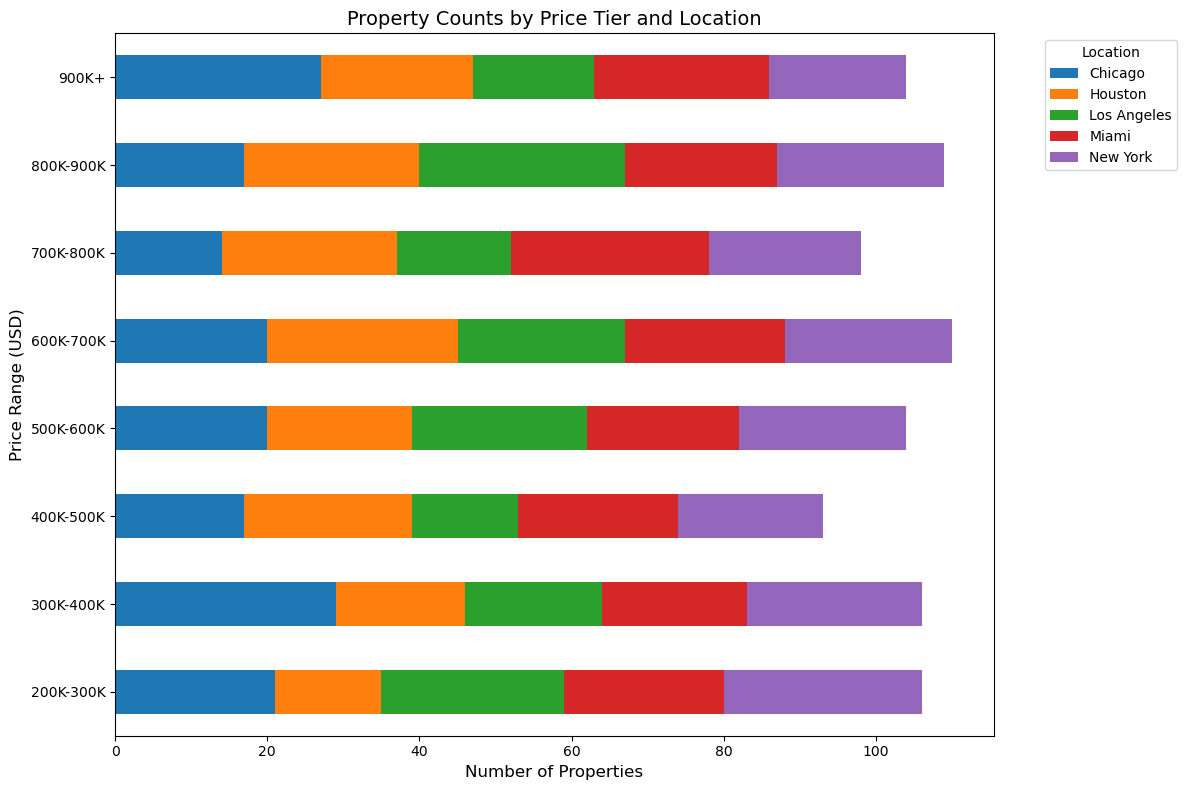

In [13]:
stack_data.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 8),
)

# Customize
plt.title('Property Counts by Price Tier and Location', fontsize=14)
plt.xlabel('Number of Properties', fontsize=12)
plt.ylabel('Price Range (USD)', fontsize=12)
plt.legend(title='Location', bbox_to_anchor=(1.05, 1))  # Move legend outside
plt.tight_layout()
plt.show()

#### *Basic Analysis*

In [14]:
#see the correlation between property size and price
properties[['Size_sqm', 'PriceUSD']].corr()

,Size_sqm,PriceUSD
Size_sqm,1.00000,0.02679
PriceUSD,0.02679,1.00000


the correlation is not significant so let's use a Hypothesis Test to ensure if Size doesn't really affect the Price.

In [15]:
from scipy.stats import pearsonr
corr, p_value = pearsonr(properties['Size_sqm'], properties['PriceUSD'])
print(f"Correlation: {corr:.4f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject H₀: Size significantly affects price.")
else:
    print("Fail to reject H₀: Size has no significant evidence of impact on price.")

Correlation: 0.0268, p-value: 0.3974
Fail to reject H₀: Size has no significant evidence of impact on price.


In [16]:
#lets see the impact of Location on price per sqm of the property
properties['Price_per_sqm'] = properties['PriceUSD'] / properties['Size_sqm']
sqm_price_per_location = properties.groupby('Location')['Price_per_sqm'].mean().sort_values(ascending=False)
sqm_price_per_location

Location
Chicago        2820.051520
Miami          2725.699262
Houston        2703.518090
New York       2664.552756
Los Angeles    2618.623506
Name: Price_per_sqm, dtype: float64

<Axes: xlabel='PropertyType', ylabel='PriceUSD'>

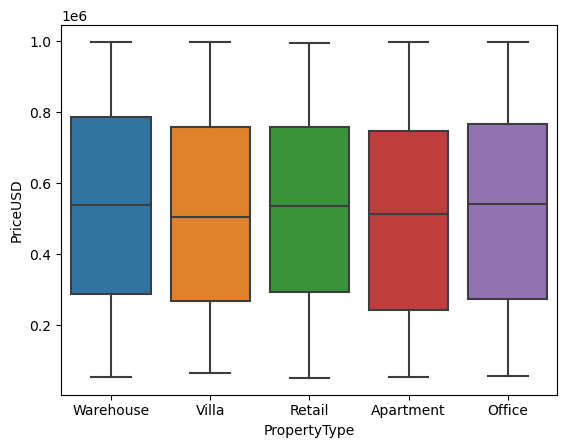

In [17]:
sns.boxplot(data=properties, x='PropertyType', y='PriceUSD')

#### Performing a simple linear regression to predict PriceUSD using the features (PropertyType, Location, Size_sqm)

In [18]:
# One-hot encode categorical features
df_dummied = pd.get_dummies(properties, columns=['PropertyType', 'Location'], drop_first=True)
df_dummied

,PropertyID,Size_sqm,PriceUSD,PriceTier,Price_per_sqm,PropertyType_Office,PropertyType_Retail,PropertyType_Villa,PropertyType_Warehouse,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York
0,1,289,933123,900K+,3228.799308,False,False,False,True,False,False,False,True
1,2,412,919739,900K+,2232.376214,False,False,True,False,False,False,True,False
2,3,213,597561,500K-600K,2805.450704,False,False,True,False,False,False,False,True
3,4,88,227159,200K-300K,2581.352273,False,False,True,False,False,True,False,False
4,5,485,593105,500K-600K,1222.896907,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,73,118846,NaN,1628.027397,False,True,False,False,False,False,False,True
996,997,292,297432,200K-300K,1018.602740,False,True,False,False,False,False,True,False
997,998,222,613594,600K-700K,2763.936937,False,True,False,False,False,False,False,True
998,999,56,151444,NaN,2704.357143,True,False,False,False,False,False,False,False


In [19]:
# Convert boolean columns to integers (1/0)
bool_cols = df_dummied.select_dtypes(include='bool').columns
df_dummied[bool_cols] = df_dummied[bool_cols].astype(int)

In [20]:
import statsmodels.api as sm 

x = df_dummied.drop(['PropertyID', 'PriceUSD', 'PriceTier'], axis=1)
y = df_dummied['PriceUSD']

# add constant
x = sm.add_constant(x)

# fit the model
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               PriceUSD   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     101.1
Date:                Sun, 18 May 2025   Prob (F-statistic):          1.01e-143
Time:                        23:32:16   Log-Likelihood:                -13603.
No. Observations:                1000   AIC:                         2.723e+04
Df Residuals:                     989   BIC:                         2.728e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -6.7

In [21]:
import statsmodels.formula.api as smf

model = smf.ols(
    formula='PriceUSD ~ Size_sqm + C(PropertyType) + C(Location) + Size_sqm:C(Location)',
    data=properties
).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               PriceUSD   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.5185
Date:                Sun, 18 May 2025   Prob (F-statistic):              0.914
Time:                        23:32:17   Log-Likelihood:                -13951.
No. Observations:                1000   AIC:                         2.793e+04
Df Residuals:                     986   BIC:                         2.800e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

- All features (Size_sqm, property types, locations) have p-values > 0.05, **meaning none significantly predict price**. 
- The relationship between size and price doesn’t vary by location/property type (Interactions Don’t Matter).

## Property Market Analysis Summary

- The extremely low correlation (**0.02679**) and p-value (**0.3974**) between `Price` and `Size_sqm` suggests that:  
  - Property prices are **not influenced by size**.  
  - Other factors (location, property type, amenities) likely drive pricing more significantly.  

- After applying the regression models I infered that non of the features is a good predictor for the price. This might be because of data quality issues as there is no clear outliers of skewness variables

- **Chicago** has the highest mean price per sqm (**$2,820**), followed by **Miami** ($2,726) and **Houston** ($2,704).  
- **Los Angeles** trails despite its high demand, possibly due to larger property sizes diluting the price per sqm.  

- **Mid-range properties (300K-600K)** dominate most locations, especially **Chicago** and **Houston**.  
- **Luxury segments (900K+)** are concentrated in **Miami** and **Los Angeles**, aligning with their premium markets.

In [22]:
sales = pd.read_sql_query("select * from Sales", conn)
sales.sample(10)

C:\Users\mokha\AppData\Local\Temp\ipykernel_2204\2265653081.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales = pd.read_sql_query("select * from Sales", conn)


,SaleID,PropertyID,ClientID,AgentID,SaleDate,SalePrice
884,885,569,317,18,2024-08-17,669247
1180,1181,883,906,62,2023-09-11,466493
168,169,237,670,89,2024-04-06,598792
123,124,337,419,87,2024-01-02,461157
1017,1018,512,906,30,2023-12-03,647643
534,535,445,1294,61,2025-04-07,1343181
415,416,482,863,56,2025-01-07,939356
894,895,36,592,23,2025-02-11,964616
651,652,721,381,61,2024-05-18,944536
1798,1799,523,1245,68,2023-08-11,1308468


In [23]:
#check for missingness
sales.isnull().sum()

SaleID        0
PropertyID    0
ClientID      0
AgentID       0
SaleDate      0
SalePrice     0
dtype: int64

In [24]:
#check for duplication
sales.duplicated().sum()

0

In [25]:
#trimming column names
sales.columns = sales.columns.str.strip()

In [26]:
#checking data types of the columns
sales.dtypes

SaleID         int64
PropertyID     int64
ClientID       int64
AgentID        int64
SaleDate      object
SalePrice      int64
dtype: object

In [27]:
#edition SaleDate type to date
sales.SaleDate = pd.to_datetime(sales['SaleDate'], errors='coerce')
sales.dtypes

SaleID                 int64
PropertyID             int64
ClientID               int64
AgentID                int64
SaleDate      datetime64[ns]
SalePrice              int64
dtype: object

In [28]:
#Date validity
inconsistency = sales[sales['SaleDate'] > pd.Timestamp.today()]
inconsistency

,SaleID,PropertyID,ClientID,AgentID,SaleDate,SalePrice


In [29]:
#Negative or zero values
inconsistency = sales[sales["SalePrice"] <= 0]
inconsistency

,SaleID,PropertyID,ClientID,AgentID,SaleDate,SalePrice


Referential Integrity is already satisfied as I applied it as constraints in the DataBase (SQL SERVER)

In [30]:
#adding derived columns for future use
sales['year'] = sales['SaleDate'].dt.year
sales['year_month'] = sales['SaleDate'].dt.to_period('M')

print(sales[['SaleDate', 'year', 'year_month']].sample(10))
print("Years covered in the data: ", sales.year.unique())

       SaleDate  year year_month
1293 2024-03-06  2024    2024-03
1808 2025-04-17  2025    2025-04
1291 2024-06-20  2024    2024-06
259  2023-11-17  2023    2023-11
1738 2024-10-08  2024    2024-10
1389 2023-11-18  2023    2023-11
1707 2024-08-31  2024    2024-08
859  2024-09-05  2024    2024-09
1173 2024-10-09  2024    2024-10
1011 2023-12-17  2023    2023-12
Years covered in the data:  [2025 2024 2023]


In [31]:
sales['SalePrice'].describe()

count    2.000000e+03
mean     7.694745e+05
std      4.210229e+05
min      6.004600e+04
25%      4.070388e+05
50%      7.453135e+05
75%      1.140800e+06
max      1.499822e+06
Name: SalePrice, dtype: float64

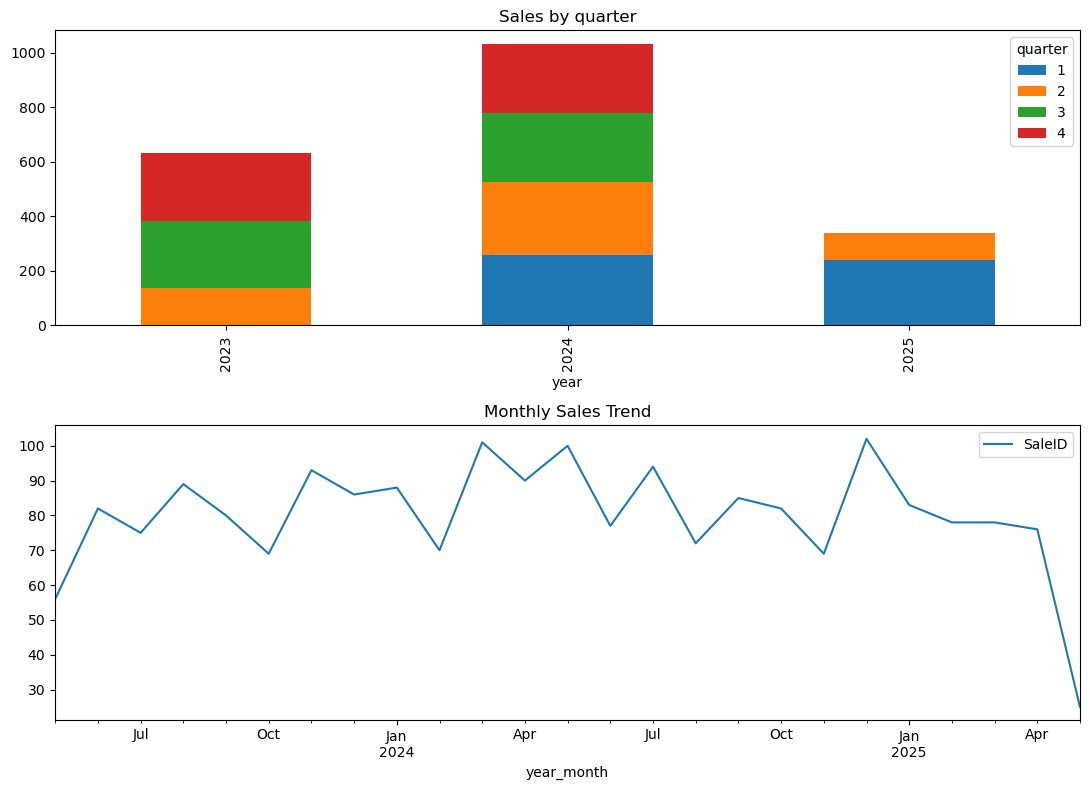

In [39]:
#add quarter column
sales['quarter'] = sales['SaleDate'].dt.quarter

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 8))

#quarterly sales
quarterly = sales.groupby(['year', 'quarter'])['SaleDate'].count().unstack()
quarterly.plot(kind='bar', ax=ax1, title='Sales by quarter', stacked=True)

#monthly sales
monthly = sales.groupby('year_month').agg({'SaleID':'count'})
monthly.plot(kind='line', ax=ax2, title='Monthly Sales Trend')

plt.tight_layout()
plt.show()

<Axes: title={'center': 'Monthly Sales Trend'}, xlabel='year_month'>

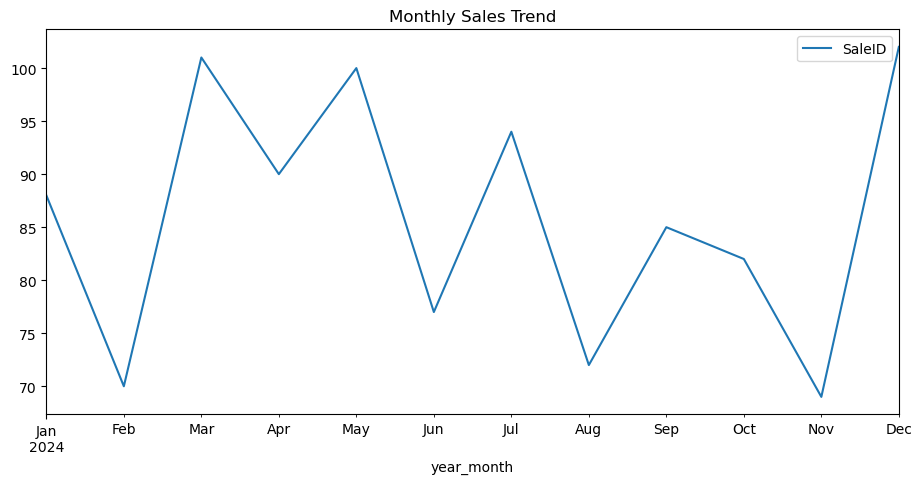

In [ ]:
#2024 monthly sales
monthly = sales[sales['SaleDate'].dt.year == 2024].groupby('year_month').agg({'SaleID':'count'})
monthly.plot(kind='line', title='Monthly Sales Trend', figsize=(11,5))

<Axes: title={'center': 'Avg Sale Price by Property Type'}, ylabel='PropertyType'>

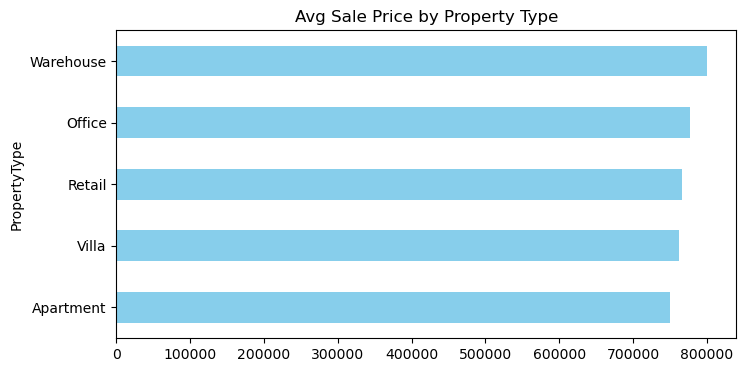

In [41]:
#Average Sale Price by Property Type
sales_props = sales.merge(properties, left_on="PropertyID", right_on="PropertyID")

sales_props.groupby("PropertyType")["SalePrice"].mean().sort_values().plot(
    kind='barh', title="Avg Sale Price by Property Type", figsize=(8,4), color='skyblue')

<Axes: title={'center': 'Total Sales by City'}, xlabel='Location'>

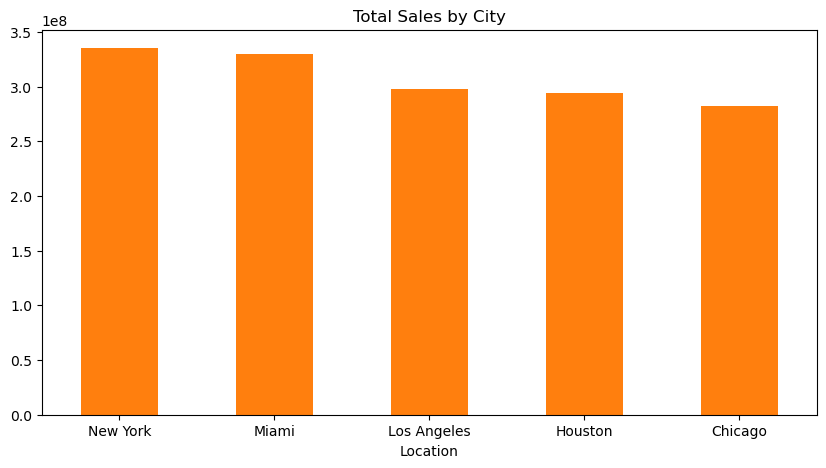

In [47]:
#Sales Distribution by City
sales_props.groupby("Location")["SalePrice"].sum().sort_values(ascending=False).plot(
    kind='bar', title="Total Sales by City", figsize=(10,5), color='#ff7f0e', rot=0)

C:\Users\mokha\AppData\Local\Temp\ipykernel_2204\3188740847.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  agents = pd.read_sql_query("select * from Agents", conn)


<Axes: title={'center': 'Top 10 Agents by Total Sales Value'}, xlabel='Sales in Millions', ylabel='FirstName,LastName'>

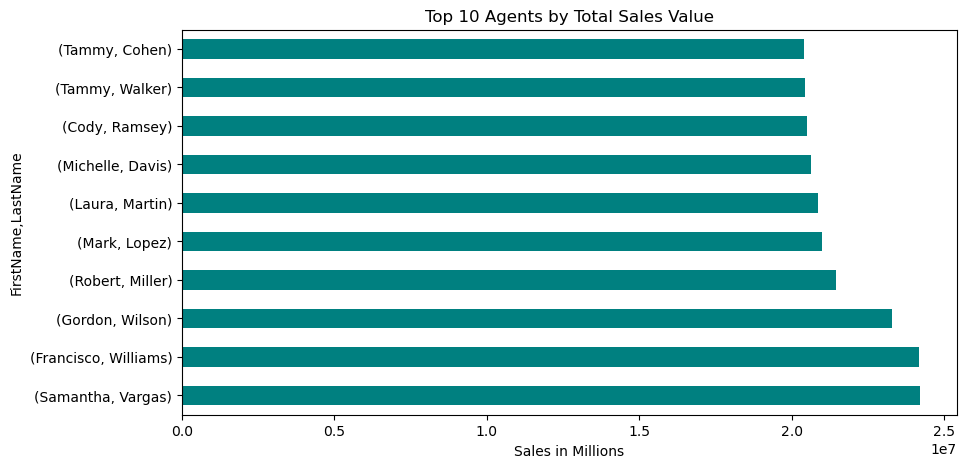

In [ ]:
#Top Performing Agents
agents = pd.read_sql_query("select * from Agents", conn)

sales_agents = sales.merge(agents, left_on="AgentID", right_on="AgentID")
sales_agents_props = sales_agents.merge(properties, left_on="PropertyID", right_on="PropertyID")

top_agents = sales_agents_props.groupby(["FirstName", "LastName"])["SalePrice"].sum().sort_values(ascending=False).head(10)
top_agents.plot(kind='barh', title="Top 10 Agents by Total Sales Value", xlabel="Sales in Millions", figsize=(10, 5), color='teal')



        Location  FirstName  LastName  AgentID  SalePrice
46       Chicago      Kelli     Davis       17    8300189
81       Chicago      Scott     Hayes       51    7688996
3        Chicago     Angela  Anderson       86    7229487
181      Houston     Sharon      Ross       54    8412268
167      Houston    Michele   Coleman       52    8341530
194      Houston    William   Maxwell       58    6591032
230  Los Angeles   Jennifer       Lin       30    8000242
269  Los Angeles       Paul    Brooks       33    7656208
220  Los Angeles  Francisco  Williams       91    6852704
354        Miami      Laura    Martin       14   10844980
343        Miami      Kelly    Harris       34    9869187
295        Miami        Amy    Howard       75    6858007
460     New York       Mark  Matthews       43   10367085
399     New York       Anna    Harper       68    9253251
484     New York     Taylor     Clark       36    7537501


<Figure size 1600x900 with 0 Axes>

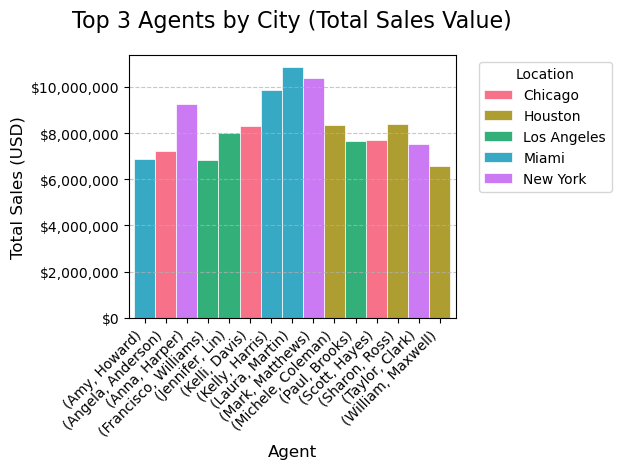

In [90]:
#Top agents by  location
top_agents_city = sales_agents_props.groupby(["Location", "FirstName", "LastName", 'AgentID'])["SalePrice"].sum().reset_index()
top_by_city = top_agents_city.sort_values(["Location", "SalePrice"], ascending=[True, False]).groupby("Location").head(3)
print(top_by_city)

top_agents_city = sales_agents_props.groupby(["Location", "FirstName", "LastName", 'AgentID'])["SalePrice"].sum().reset_index()
top_by_city = top_agents_city.sort_values(["Location", "SalePrice"], ascending=[True, False]).groupby("Location").head(3)

pivoted = pd.pivot(top_by_city, index=['FirstName', 'LastName'], columns='Location', values='SalePrice')

plt.figure(figsize=(16, 9))
ax = pivoted.plot(kind='bar', stacked=True, color=sns.color_palette("husl", len(pivoted.columns)), width=1, edgecolor='white', linewidth=0.5)

plt.title("Top 3 Agents by City (Total Sales Value)", fontsize=16, pad=20)
plt.xlabel("Agent", fontsize=12)
plt.ylabel("Total Sales (USD)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

#format currency on y-axis
ax.yaxis.set_major_formatter('${x:,.0f}')

plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()